**Collaborated with student Sophie Guo, Fanxi Chen, Yitong Zhao**

### Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime # convert string to datetime

from statsmodels.tsa.stattools import adfuller # test stationality
from statsmodels.tsa.seasonal import seasonal_decompose # decompose seasonality

from statsmodels.graphics.tsaplots import plot_acf # plot ACF
from statsmodels.graphics.tsaplots import plot_pacf # plot PACF

In [2]:
alcohol_data = pd.read_csv("../W9/Alcohol_Sales.csv", )
alcohol_data.head()

,DATE,units_sold
0,January-92,3459
1,February-92,3458
2,March-92,4002
3,April-92,4564
4,May-92,4221


In [3]:
alcohol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        325 non-null    object
 1   units_sold  325 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


*The DATE column is in object (string) instead of datetime format.*

### 1. The date information is in a non-standard format. You will need to convert it to a datetime.

In [4]:
alcohol_data["DATE"] =  [datetime.strptime(x, '%B-%y') for x in alcohol_data["DATE"]]
alcohol_data.head()

,DATE,units_sold
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221


In [5]:
alcohol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        325 non-null    datetime64[ns]
 1   units_sold  325 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.2 KB


### 2. Make the date value an index using set_index()

In [6]:
alcohol = alcohol_data.set_index("DATE")
alcohol.head()

,units_sold
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


### 3. Plot the number of units sold vs time. 

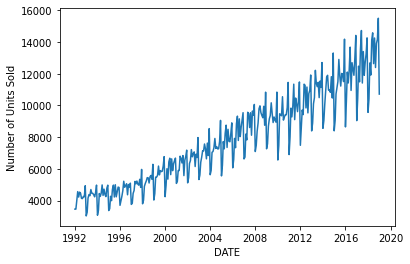

In [7]:
plt.xlabel("DATE")
plt.ylabel('Number of Units Sold')
plt.plot(alcohol)

**a. Are data independent?**  
*Data is not independent. Data is measured across time, and there is a clear time trend.*  
**b. Is the data stationary?**  
*The data is not stationary. The mean of sales increases over time, and variance increases over time.*

### 4. Make the data stationary using differencing.

In [8]:
# take log of sales to lower the rate at which rolling mean increases
# sales_log = np.log(alcohol["units_sold"])
# plt.plot(sales_log)

# sales_log_shift = sales_log - sales_log.shift()
# sales_log_shift.dropna(inplace=True)
# plt.plot(sales_log_shift)

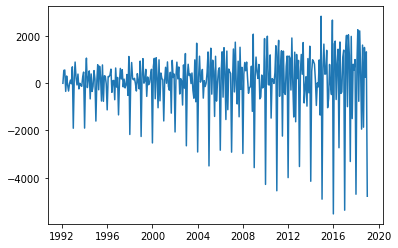

In [9]:
sales_shift = alcohol["units_sold"] - alcohol["units_sold"].shift()
sales_shift.dropna(inplace=True)
plt.plot(sales_shift)

*After shifting, units sold would have a constant mean. Data variance, however, still changes over time.*

### 5. Use this function to test whether the series is stationary.

In [10]:
def get_stationarity(timeseries, varname): 
    """Title: get_stationerity
    Function for testing whether time series data is stationery. 
    
    Args: 
    timeseries - Dateframe containing time series 
    varname - Name of the column containing the series values 
    """ 
    # rolling statistics 
    rolling_mean = timeseries.rolling(window=12).mean() 
    rolling_std = timeseries.rolling(window=12).std() 
    
    # rolling statistics plot 
    original = plt.plot(timeseries, color='blue', label='Original') 
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean') 
    std = plt.plot(rolling_std, color='black', label='Rolling Std') 
    plt.legend(loc='best') 
    plt.title('Rolling Mean & Standard Deviation') 
    plt.show(block=False) 
    
    # Dickey–Fuller test: 
    result = adfuller(timeseries[varname]) 
    
    print('ADF Statistic: {}'.format(result[0])) 
    print('p-value: {}'.format(result[1])) 
    print('Critical Values:') 
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

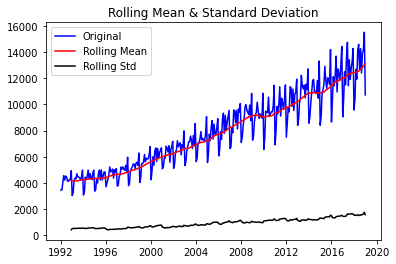

ADF Statistic: 2.0374047259136874
p-value: 0.9987196267088919
Critical Values:
	1%: -3.451621854687657
	5%: -2.870908950689806
	10%: -2.571761810613944


In [11]:
# raw data
get_stationarity(alcohol, "units_sold") 

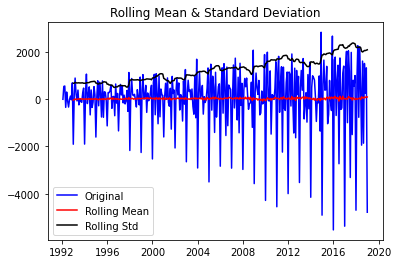

ADF Statistic: -4.365959619246054
p-value: 0.0003408284921170007
Critical Values:
	1%: -3.451621854687657
	5%: -2.870908950689806
	10%: -2.571761810613944


In [12]:
# shifted data
sales_shift = pd.DataFrame(data = sales_shift, columns = ["units_sold"]) # make it a dataframe
get_stationarity(sales_shift, "units_sold")

**a. Did differencing make the data stationery?**  
*Yes. The p-value after applying log and shift() on sales is smaller than 0.05, meaning that it is stationary.*  
**b. Do you see another issue with the data? Hint: Think about the other regression assumptions, apart from independence.**  
*The sales do not have constant variance (if log transformation is not taken). After applied shift(), the data has constant mean, but the variance is still increasing across time.*

### 6. Generate ACF and PACF plots of the differenced data.

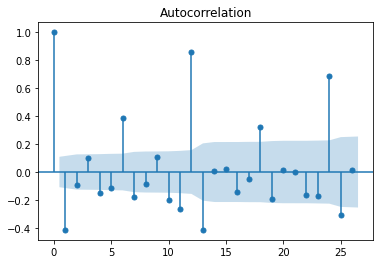

In [14]:
plot_acf(sales_shift.units_sold)
plt.show()

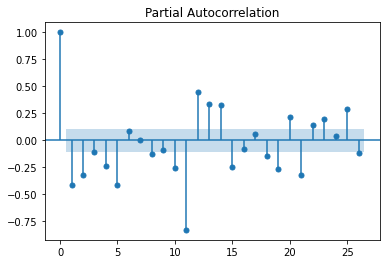

In [16]:
plot_pacf(sales_shift.units_sold)
plt.show()

**a. Would a time series model be appropriate?**  
*Yes. There is clearly a time trend, and data is not independent.*  
**b. Will this require an ARIMA or a SARIMA model? Explain.**  
*This would require a SARIMA model. From the ACF and stationality check graphs, as well as the decomposed seasonality graph below, we can tell there is seasonality, so a SARIMA model would be more appropriate.*

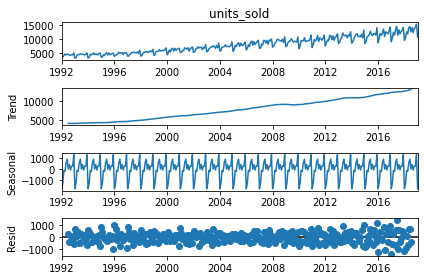

In [17]:
decompose = seasonal_decompose(alcohol["units_sold"])
decompose.plot()
plt.show()